# Weekdays vs Weekends

## Libraries import

In [2]:
library(tidyverse)
library(dplyr)
library(ggplot2)

In [3]:
Sys.setlocale("LC_TIME","C")
options(stringsAsFactors=FALSE)
theme_set(theme_bw()) # just my preference for plots

[1] "C"

## Data import and structuring

In [4]:
read_met <- function(filename) {
  data <- read_table(filename, skip=15, 
    col_names= c("year", "month", "day", "hour", "minute", "WIRI", "WIGE"),
    col_types = paste(collapse = "", c(rep("i", 5), rep("n", 2))))
  data %>%
    mutate(datetime = make_datetime(year, month, day, hour, minute, tz = "CEST"),
           year     = year(datetime),
           month    = month(datetime),
           day      = day(datetime),
           hour     = hour(datetime),
           minute   = minute(datetime),
           WIRI     = ifelse(WIRI <= -9999, NA, WIRI),
           WIGE     = ifelse(WIGE <= -9999, NA, WIGE))
}

In [5]:
month2season <- function(month) {
  ## month is an integer (1-12)
  ## a factor with levels {"Winter : DJF", "Spring : MAM", "Summer : JJA", "Autumn : SON"} is returned
  seasons <- c("Winter", "Spring", "Summer", "Autumn")
  index <- findInterval(month %% 12, seq(0, 12, 3))
  factor(seasons[index], seasons)
}

wday2type <- function(wday) {
  ## wday is an integer with 1 = Monday, 2 = Tuesday, ... and 7 = Sunday
  c("Weekday", "Weekend")[(unclass(wday) - 1) %/% 5 + 1]
}

In [6]:
read_tseries <- function(filename, timecolumn = "Date/time", timeformat = "%d.%m.%Y %H:%M", tz = "Etc/GMT-1", delta = 3600) {
  ## read the table, strip units in column names, rename time column
  ##   and change data type of time column from a string of characters to
  ##   a numeric type so that we can perform operations on it

  data <- read_delim(filename, skip = 5, delim = ";", locale = locale(encoding = "Latin1"), show_col_types = FALSE)

  out <- data %>%
    rename_with(.fn = function(x) sub("[ ].*$", "", x)) %>% # strip units for simplification
    rename(datetime = !!timecolumn) %>%
    mutate(datetime = parse_date_time(datetime, !!timeformat, !!tz) - !!delta) %>%
    mutate(year = year(datetime),
           month = month(datetime),
           day = day(datetime),
           hour = hour(datetime),
           dayofwk = wday(datetime, label = TRUE, week_start = 1),
           daytype = wday2type(dayofwk),
           season = month2season(month),
           .after = datetime)
}

In [7]:
datapath <- file.path("Data")

all_data_df <- full_join(
  bind_cols(site="DAV", read_tseries(file.path(datapath, "DAV.csv"))),
  bind_cols(site="BAS", read_tseries(file.path(datapath, "BAS.csv")))
)

#all_data_df

Joining with `by = join_by(site, datetime, year, month, day, hour, dayofwk, daytype, season, O3, NO2, PM10, NOX, TEMP,
PREC, RAD)`


In [8]:
all_data_lf <- all_data_df %>%
  pivot_longer(-c(site, datetime, season, year, month, day, hour, dayofwk, daytype),  # id columns
               names_to = "variable",
               values_to = "value")

## Pollutants' results 

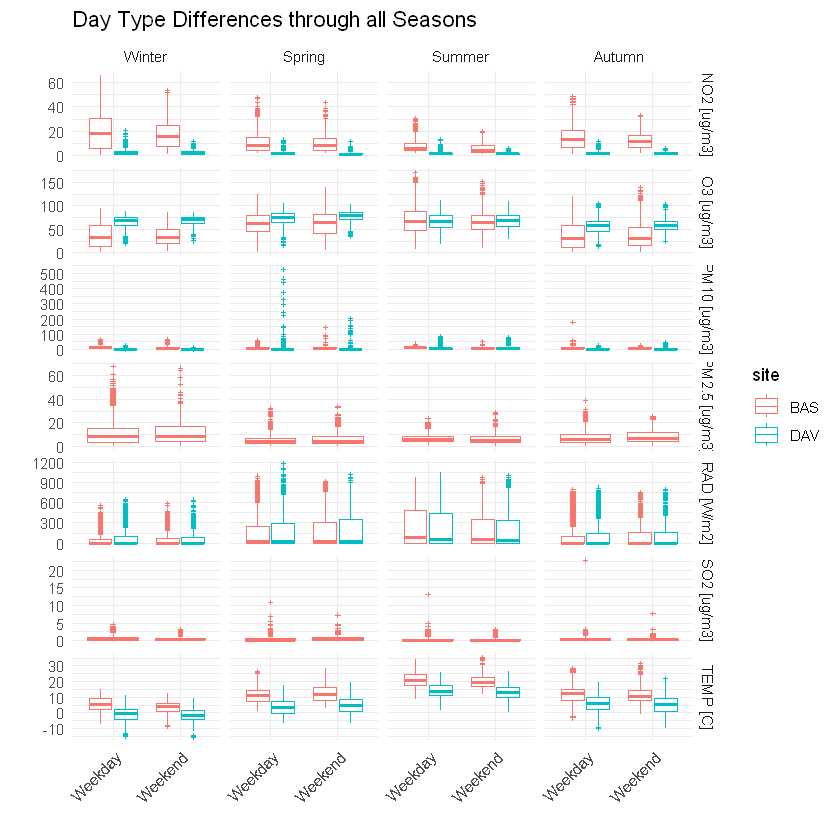

In [9]:
# both sites on the same graph
daytype<-all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & !variable %in% c("CPC", "EC", "NOX", "PREC"))
  
daytype_plot<-ggplot(daytype) +
  facet_grid(variable ~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    )
  )) + 
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Day Type Differences through all Seasons"  # Title for the plot
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

daytype_plot

ggsave("outputs/daytype.jpeg", plot = daytype_plot, width = 9, height = 9, dpi = 300)

## Precipitation analysis

`summarise()` has grouped output by 'daytype', 'variable', 'season'. You can override using the `.groups` argument.
Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


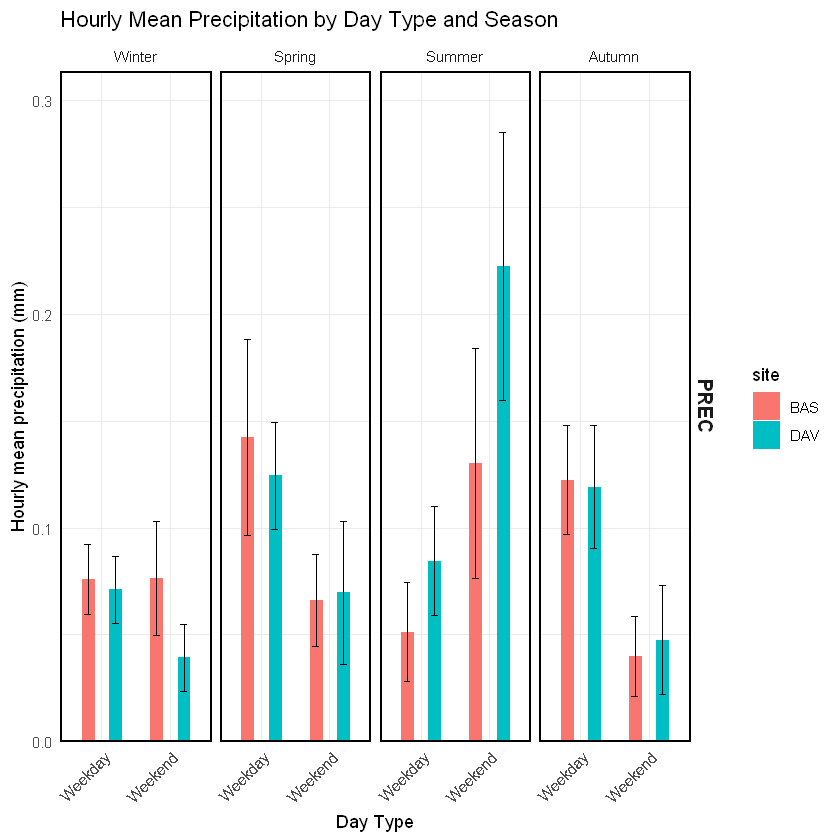

In [10]:
Precipitation_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season, site) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  )

precipitations_plot_1 <-ggplot(Precipitation_data,
    aes(
    x = daytype, 
    y = mean_value, 
    color = site,
    fill=site
  )
) +
  facet_grid(variable ~ season, scales = "free_y") +
  # Adjust the dodge width for bars and error bars to avoid superimposition
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +  # Mean values as bars
  geom_errorbar(
    aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
    width = 0.2, 
    position = position_dodge(width = 0.8),  # Align error bars with the bars for each site
    color = "black"
  ) +  # 95% CI error bars
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Hourly Mean Precipitation by Day Type and Season"  # Title for the plot
  ) +
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

precipitations_plot_1

ggsave("outputs/precipitations_DayType_sites.jpeg", plot = precipitations_plot_1, width = 6, height = 5, dpi = 300)


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."


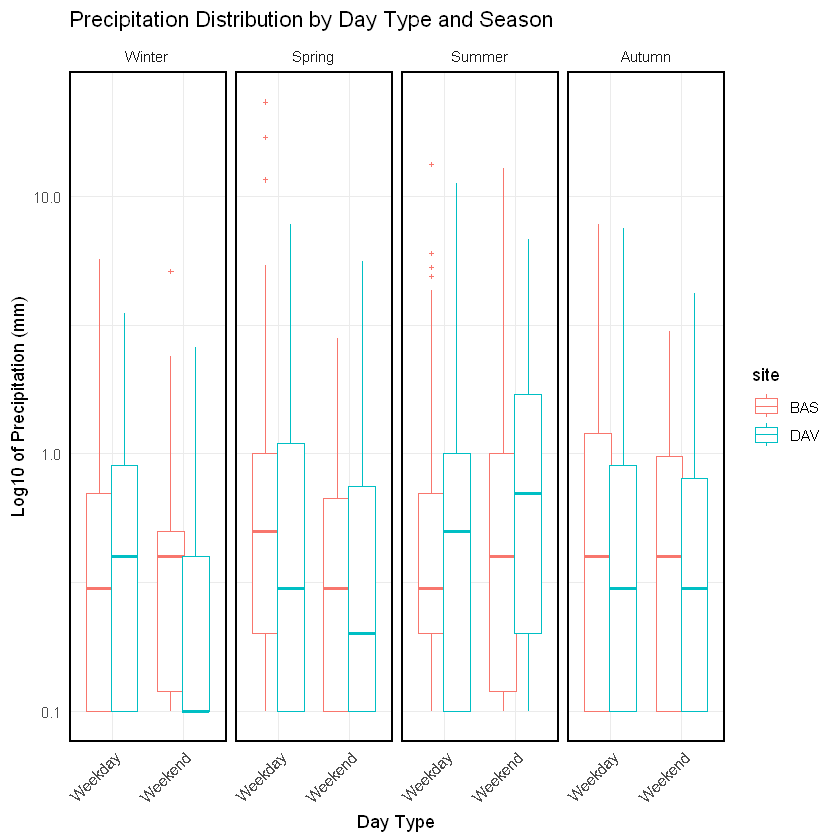

In [11]:
library(ggplot2)
library(dplyr)

# Filter the data for the PREC variable
daytype <- all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & variable == "PREC")

# Create the plot for PREC only, with a log y scale and clear separation of seasons
daytype_plot <- ggplot(daytype) +
  facet_grid(~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "PREC" = "PREC [mm]"
    )
  )) + 
  # Add the rectangle around each season facet
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3,
    position = position_dodge(width = 0.7)  # Separate the boxplots for each season
  ) +
  scale_y_log10() +  # Apply log scale to y-axis
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Precipitation Distribution by Day Type and Season"  # Title for the plot
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
daytype_plot

# Save the plot
ggsave("outputs/daytype_prec_log_separated_seasons_with_boxes.jpeg", plot = daytype_plot, width = 6, height = 5, dpi = 300)


### Accumulated precipitations

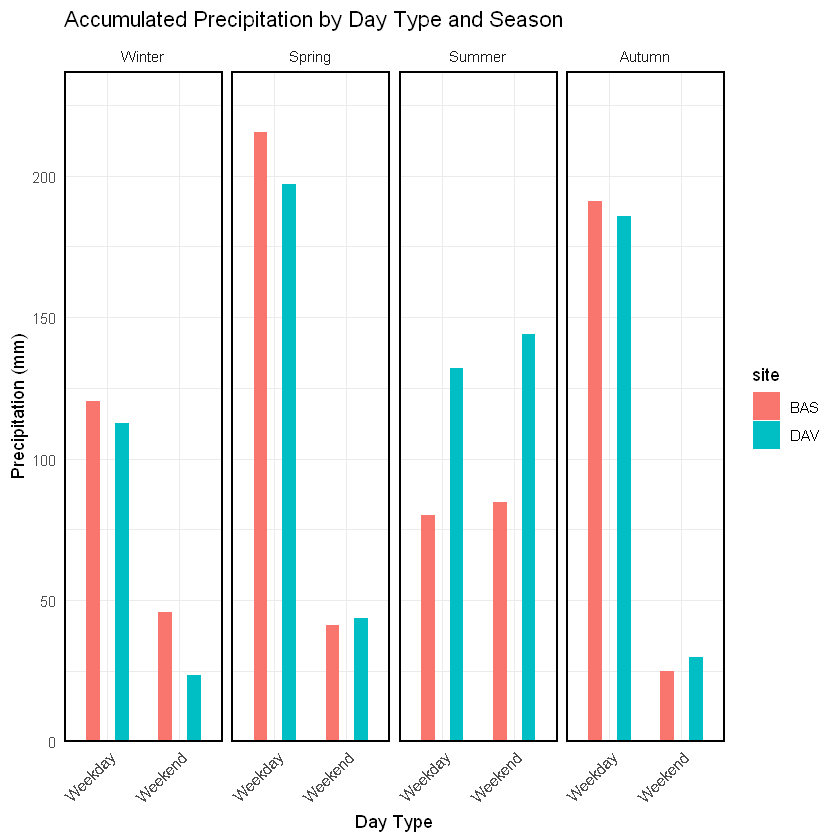

In [12]:
# Filter out NA values and calculate cumulative sum using reframe()
Precipitation_cumsum_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, season, site) %>%
  reframe(
    cumsum_value = cumsum(value)  # Compute cumulative sum for each group
  )

# Create the plot
precipitations_plot_2 <- ggplot(Precipitation_cumsum_data, aes(
    x = daytype, 
    y = cumsum_value, 
    color = site,
    fill = site
  )) +
  facet_grid(~ season, scales = "free_y") +
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +
  scale_y_continuous("Precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +  # Adjust label to reflect cumulative values
  theme_minimal() +
    labs(
    x = "Day Type",  # Label for the x-axis
    y = "Precipitation (mm)",  # Label for the y-axis
    title = "Accumulated Precipitation by Day Type and Season"  # Title for the plot
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
precipitations_plot_2

ggsave("outputs/accumulated_precipitations_1.jpeg", plot = precipitations_plot_2, width = 6, height = 5, dpi = 300)


## Weekly variations

In [24]:
head(all_data_lf)

site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<chr>,<dbl>
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,O3,57.7
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,NO2,1.9
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,PM10,1.2
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,NOX,1.9
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,TEMP,-2.2
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,PREC,0.0


In [19]:
Percentile <- function(perc) function(x) 
  ## `perc` is the percentile which should be computed for the numeric vector `x`
  quantile(x, perc*1e-2, na.rm=TRUE)

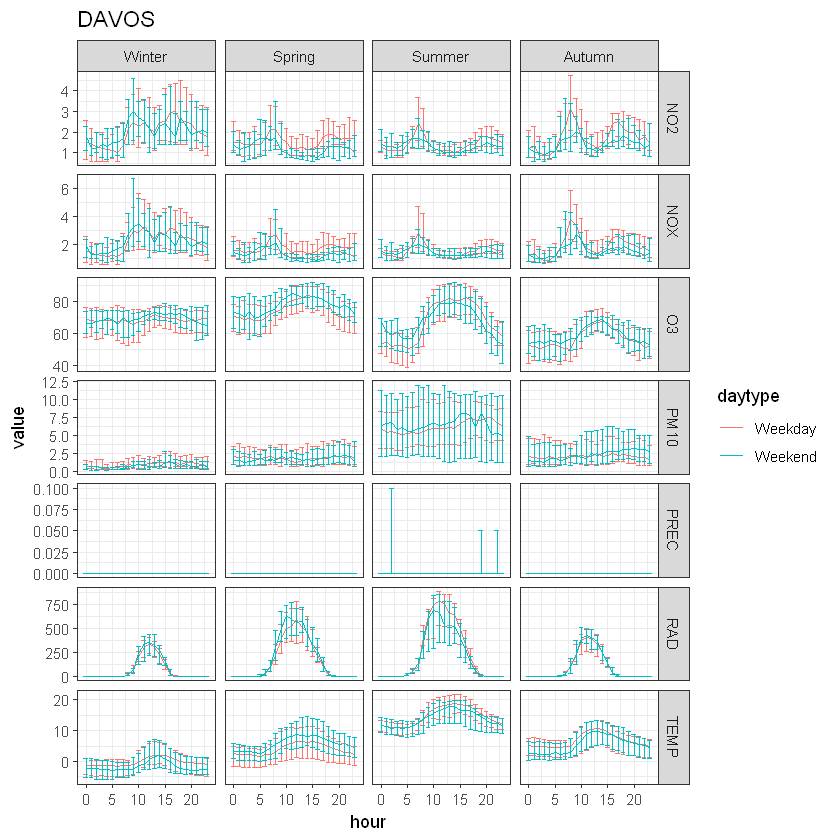

In [37]:
Diurnal_profile_DAV <- all_data_lf %>%
  filter(site=="DAV" & !is.na(value) & !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=daytype, color=daytype)) +
  facet_grid(variable ~ season, scale = "free_y", drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("DAVOS")

Diurnal_profile_DAV
ggsave("outputs/Diurnal_profile_DAV.jpeg", plot = Diurnal_profile_DAV, width = 8, height = 6, dpi = 400)

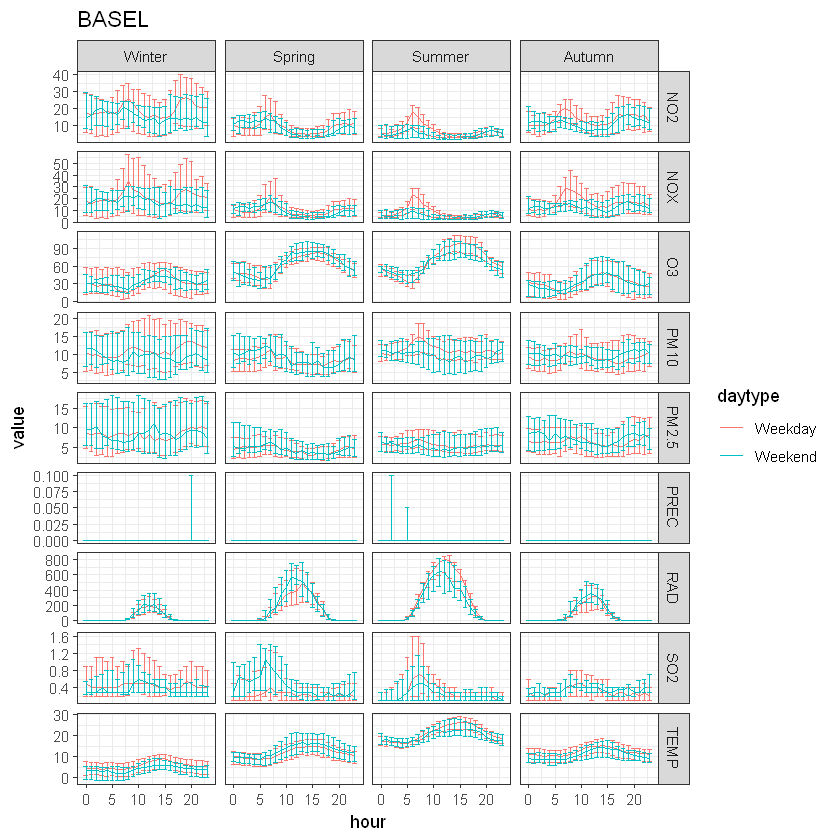

In [39]:
Diurnal_profile_BAS <- all_data_lf %>%
  filter(site=="BAS" & !is.na(value) & !is.na(season) & variable != "CPC" & variable != "EC") %>%
  ggplot(aes(x=hour, y=value, group=daytype, color=daytype)) +
  facet_grid(variable ~ season, scale = "free_y", drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("BASEL")

Diurnal_profile_BAS
ggsave("outputs/Diurnal_profile_BAS.jpeg", plot = Diurnal_profile_BAS, width = 8, height = 6, dpi = 400)

In [49]:
all_data_lf %>%
  filter(variable=="O3"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(~daysofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("O3")

ERROR while rich displaying an object: Error in `combine_vars()`:
! At least one layer must contain all faceting variables: `daysofwk`
x Plot is missing `daysofwk`
x Layer 1 is missing `daysofwk`
x Layer 2 is missing `daysofwk`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content

Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."


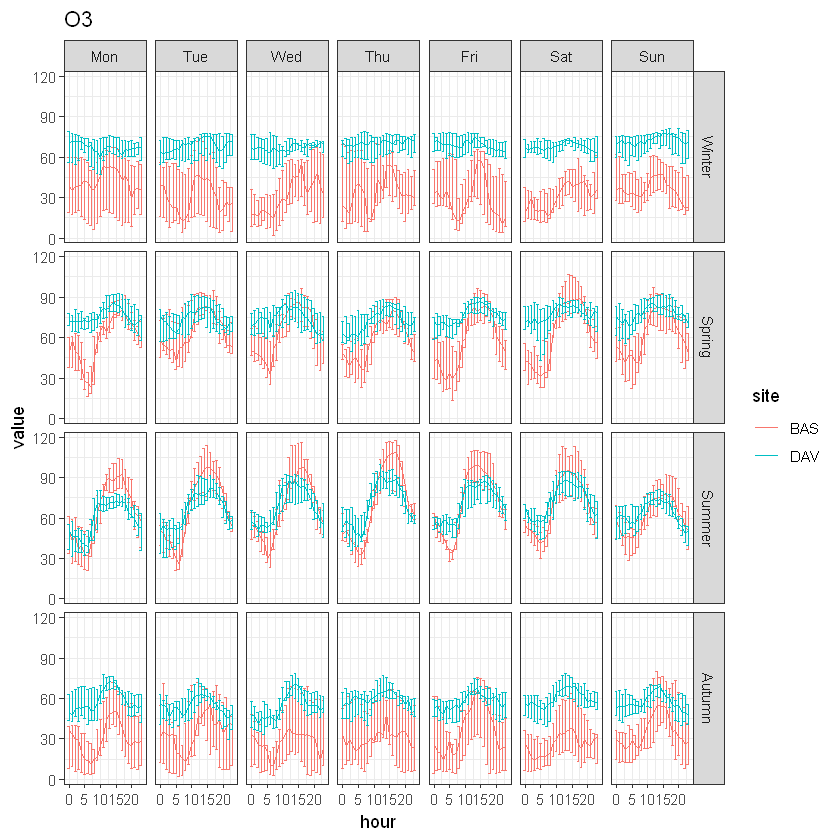

In [40]:
all_data_lf %>%
  filter(variable=="O3"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(season ~ dayofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("O3")

Warning message:
"Removed 96 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 96 rows containing non-finite values (`stat_summary()`)."


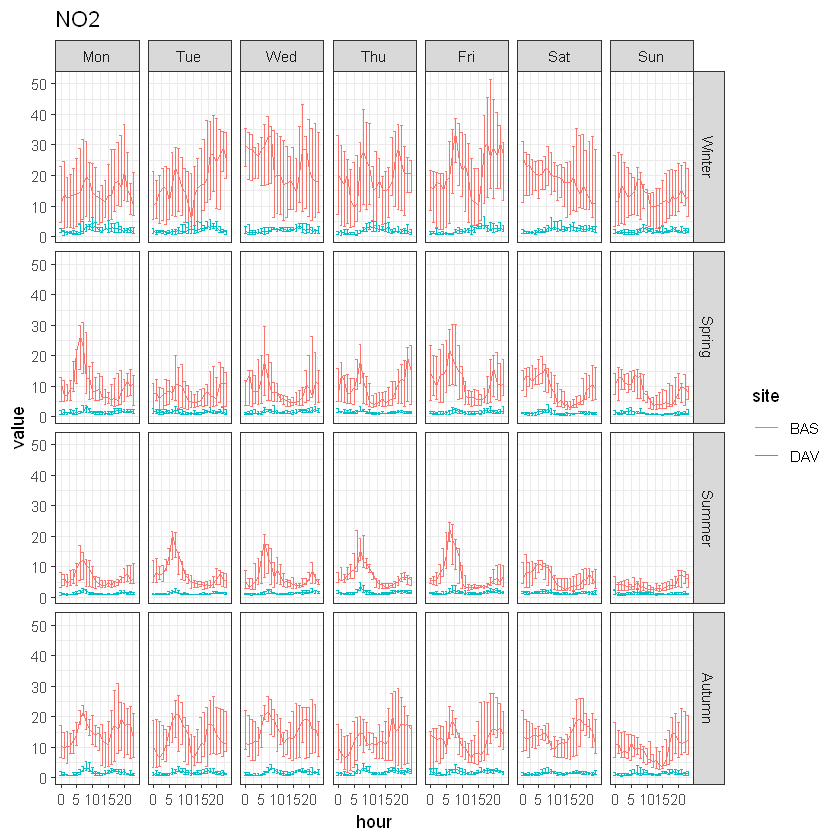

In [42]:
all_data_lf %>%
  filter(variable=="NO2"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(season ~ dayofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("NO2")

Warning message:
"Removed 96 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 96 rows containing non-finite values (`stat_summary()`)."


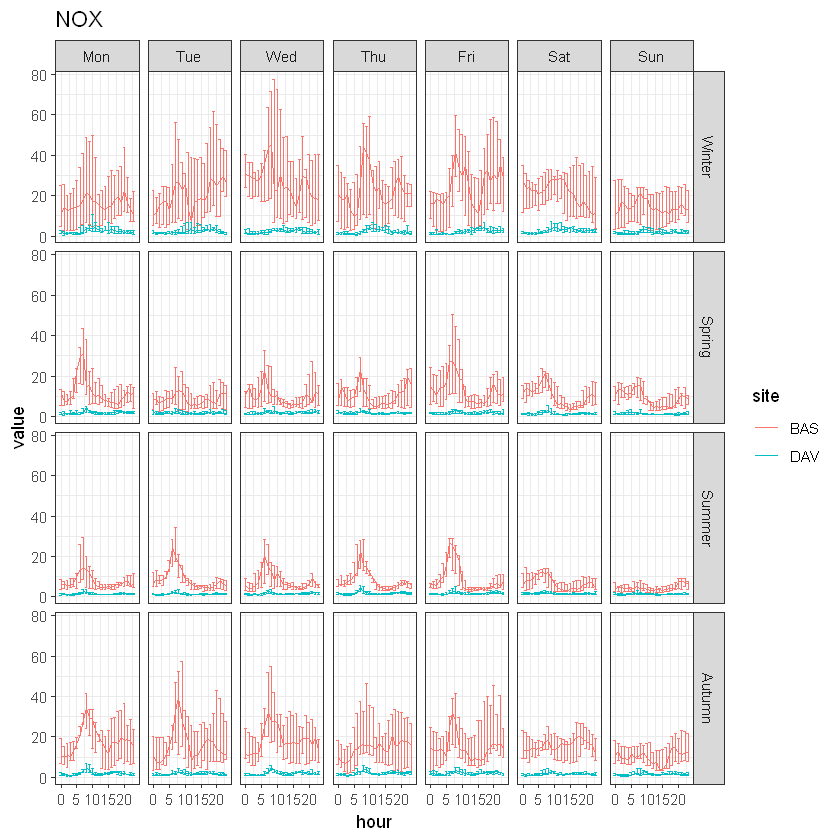

In [44]:
all_data_lf %>%
  filter(variable=="NOX"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(season ~ dayofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("NOX")

Warning message:
"Removed 211 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 211 rows containing non-finite values (`stat_summary()`)."


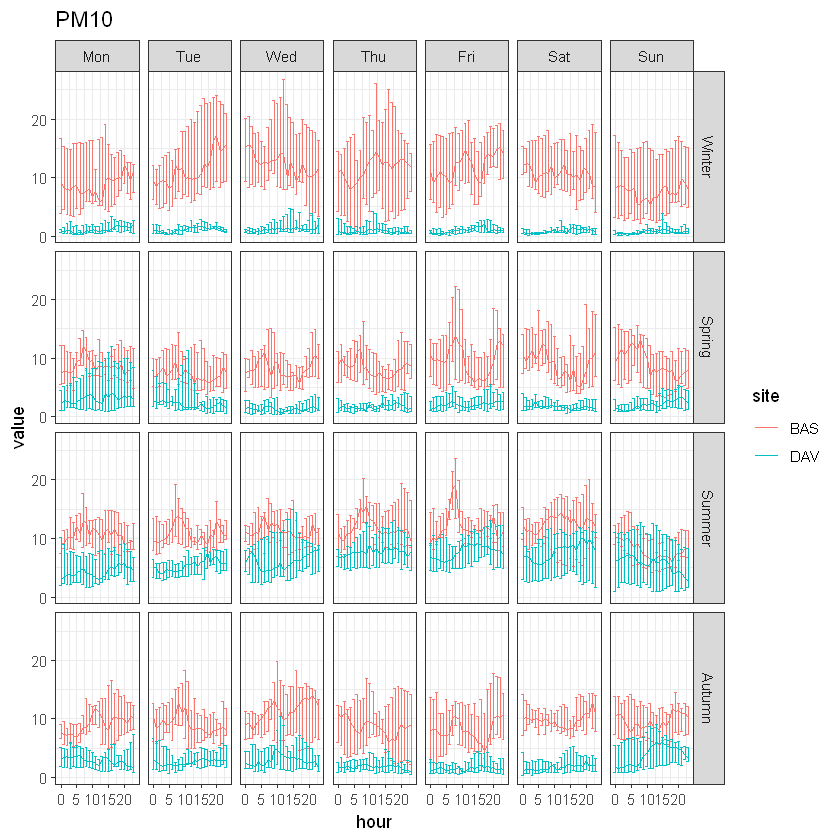

In [46]:
all_data_lf %>%
  filter(variable=="PM10"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(season ~ dayofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("PM10")